WARNING -- this is hard wired to use Bahamas quick-look data, switch to quality controlled data as it becomes available 


Distances no better than temporal resolution of orbit +/ 370 m
HALO-20240811a underpass distance 1163 m at 2024-08-11T15:51:53.8 s


/Users/m219063/Research/Projects/ORCESTRA/pyorcestra/orcestra/sat.py:174: UserWarning: You are using an old forecast (issued on 2024-08-12) for EARTHCARE on 2024-08-13! The newest forecast issued so far was issued on 2024-08-13. It's a PRE forecast.
  warnings.warn(


HALO-20240813a underpass distance 31 m at 2024-08-13T15:39:53.0 s


/Users/m219063/Research/Projects/ORCESTRA/pyorcestra/orcestra/sat.py:174: UserWarning: You are using an old forecast (issued on 2024-08-15) for EARTHCARE on 2024-08-16! The newest forecast issued so far was issued on 2024-08-16. It's a PRE forecast.
  warnings.warn(


HALO-20240816a underpass distance 37 m at 2024-08-16T16:13:56.2 s
HALO-20240818a underpass distance 287 m at 2024-08-18T16:03:59.4 s


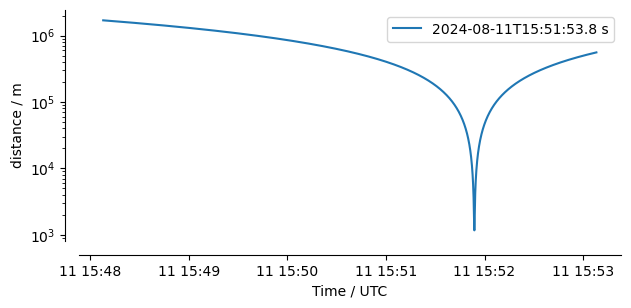

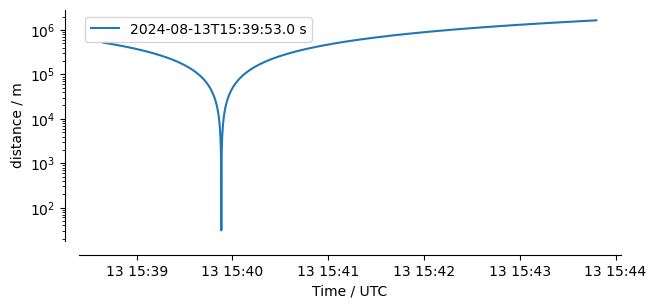

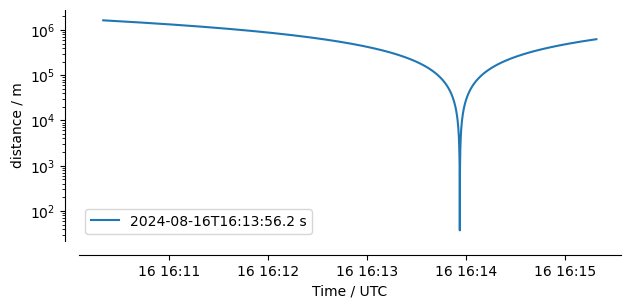

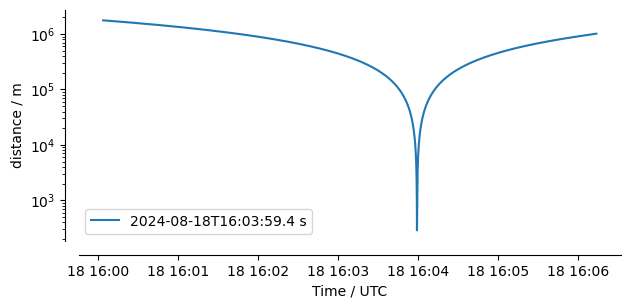

In [1]:
"""Calculate time and distance of EarthCARE overpass"""

from datetime import datetime
import xarray as xr
import orcestra.sat
import orcestra.postprocess
import orcestra.postprocess.level0
import orcestra.postprocess.level1
import matplotlib.pyplot as plt
import seaborn as sns

sig_ec = 360*60*1852/(90*600)/2.

flight_names = ['HALO-20240811a','HALO-20240813a','HALO-20240816a','HALO-20240818a']

print("WARNING -- this is hard wired to use Bahamas quick-look data, switch to quality controlled data as it becomes available \n\n")

print (f'Distances no better than temporal resolution of orbit +/ {sig_ec:3.0f} m')

for flight_name in flight_names:
    flight_date = flight_date = flight_name[5:9]+'-'+flight_name[9:11]+'-'+flight_name[11:13]
    flight_time = datetime(int(flight_name[5:9]), int(flight_name[9:11]), int(flight_name[11:13]), 12, 0, 0)
    ec_track = orcestra.sat.SattrackLoader("EARTHCARE", f"2024-08-{int(flight_name[11:13])-1:02d}", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
    ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))

    halo = xr.open_dataset('/Volumes/ORCESTRA/'+flight_name+'/bahamas/QL_'+flight_name+'_BAHAMAS_V01.nc').pipe(orcestra.postprocess.level0.bahamas).sel(time=slice(ec_track.time[0],ec_track.time[-1]))
    ec   = ec_track.interp(time=halo.time)
    az12, az21, dist = orcestra.flightplan.geod.inv(ec.lon,ec.lat,halo.IRS_LON,halo.IRS_LAT)
    print (f'{flight_name} underpass distance {dist.min():.0f} m at {halo.time[dist.argmin()].astype(str):.21s} s')

    fig, ax = plt.subplots(
        figsize=(7, 3),
        facecolor='white'
        )
    ax.plot(halo.time,dist, label=f'{halo.time[dist.argmin()].astype(str):.21s} s')
    ax.set_yscale('log')
    ax.set_xlabel('Time / UTC')
    ax.set_ylabel('distance / m')
    plt.legend()
    sns.despine(offset=10)

#plt.savefig(f'{flight_index}_track.png')